In [45]:
include("src/qsrfe.jl")

Main.qsrfe

In [2]:
using DataFrames
using HyperTuning
using Random
using Distributed

In [3]:
Random.seed!(1234)

TaskLocalRNG()

In [4]:
using LinearAlgebra
using MLJ, MLJLinearModels
X, Y = @load_boston
(xtrain, xtest), (ytrain, ytest) = qsrfe.load_dataset(X,Y;normalize=true,partitioning=0.8,rng=1234);
indexmaptrain = ytrain .<= 47
indexmaptest = ytest .<= 47
(xtrain, xtest), (ytrain, ytest) = (xtrain[indexmaptrain,:], xtest[indexmaptest,:]), (ytrain[indexmaptrain], ytest[indexmaptest]);

In [5]:
size(xtrain), size(xtest)

((389, 12), (98, 12))

In [7]:
using Plots

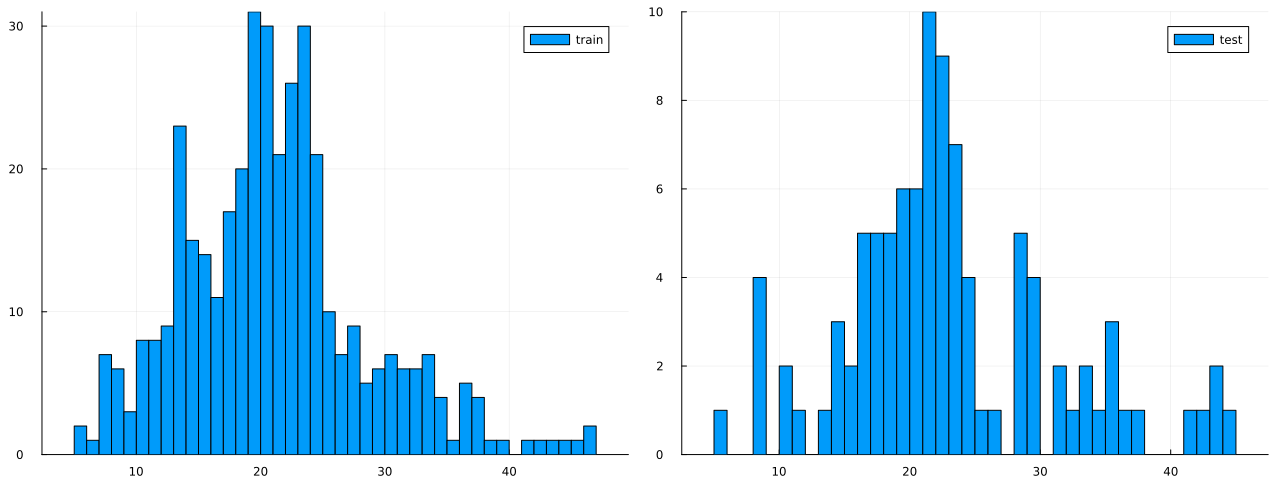

In [8]:
p1 = Plots.histogram(ytrain, label="train", bins=50)
p2 = Plots.histogram(ytest, label="test", bins=50)
plot(p1, p2, layout=(1,2), size= (1280,480),legend=true)

In [9]:
"2^8:", 2^8, "2^9:", 2^9, "2^10:", 2^10, "2^11:", 2^11, "2^12:", 2^12, "2^13:", 2^13, "2^14:", 2^14, "2^15:", 2^15, "2^16:", 2^16, "2^17:", 2^17

("2^8:", 256, "2^9:", 512, "2^10:", 1024, "2^11:", 2048, "2^12:", 4096, "2^13:", 8192, "2^14:", 16384, "2^15:", 32768, "2^16:", 65536, "2^17:", 131072)

10

support: 32768/32768
test rel: 0.12150471269258621 train rel: 0.053229583696315357
test abs: 2.0926218874841425 train abs: 0.8596686173962561
test mse: 8.695897382814831 train mse: 1.4191420029213953
test rmse: 2.9488806999970056 train rmse: 1.191277466806703


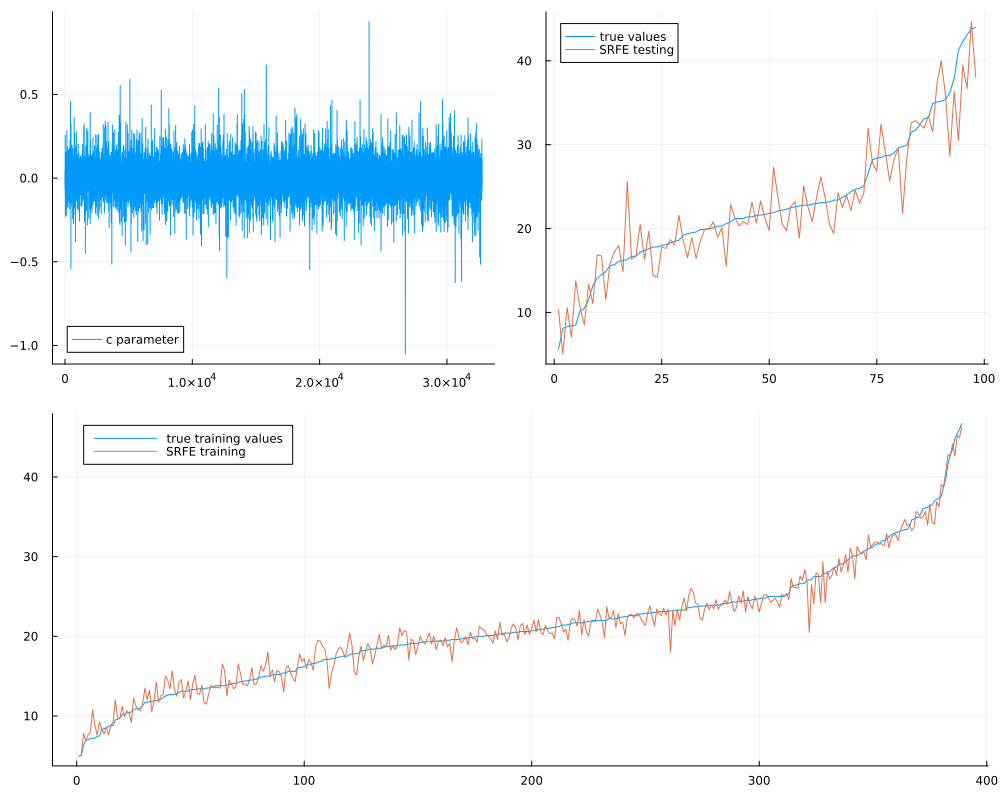

In [40]:
# Assemble all the models to test
# Hyper parameter testing cell for unquantized
N= 2^15

SRFE = qsrfe.srfeRegressor(N=N,σ2=11.0,λ=0.003, intercept=false)
RFE = qsrfe.rfeRegressor(N=N,σ2=10.0,λ=0.003, intercept=false)
#quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
model = RFE
#training and evaluating

    #no quantizaiton
c = qsrfe.fit(model, xtrain, ytrain, verbose=true) #,max_iter=2000000
ytrainpred = qsrfe.predict(model,xtrain)
ytestpred = qsrfe.predict(model, xtest)

println("")
println("test rel: ",qsrfe.rel_L2_error(ytest,ytestpred)," train rel: ",qsrfe.rel_L2_error(ytrain,ytrainpred))
println("test abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("test mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
println("test rmse: ",qsrfe.rmse(ytest,ytestpred)," train rmse: ",qsrfe.rmse(ytrain,ytrainpred))
model = SRFE
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [13]:
# evaluate the model in the cell above 5 times and get the average
# BEGIN: Evaluate the model 5 times and get the average
model = qsrfe.srfeRegressor(N=N,σ2=11.0,λ=0.0032, intercept=false)
trials = 5
mean_rel_L2_error = 0.0
mean_abs_error = 0.0
mean_mse = 0.0
mean_rmse = 0.0

for i in 1:trials
    c = qsrfe.fit(model, xtrain, ytrain, verbose=false)
    ytrainpred = qsrfe.predict(model, xtrain)
    ytestpred = qsrfe.predict(model, xtest)
    
    mean_rel_L2_error += qsrfe.rel_L2_error(ytest, ytestpred) / trials
    mean_abs_error += qsrfe.abs_error(ytest, ytestpred) / trials
    mean_mse += qsrfe.mse(ytest, ytestpred) / trials
    mean_rmse += qsrfe.rmse(ytest, ytestpred) / trials
end

println("Average test rel L2 error: ", mean_rel_L2_error)
println("Average test abs error: ", mean_abs_error)
println("Average test mse: ", mean_mse)
println("Average test rmse: ", mean_rmse)
# END: Evaluate the model 5 times and get the average

Average test rel L2 error: 0.11595894606220247
Average test abs error: 2.0380759641631117
Average test mse: 7.9223202419737415
Average test rmse: 2.8142867091910517


support: 420/1025
test rel: 0.11320964464841346 train rel: 0.08191531763216896
test abs: 1.999441394811309 train abs: 1.356285247345912
test mse: 7.549097158310969 train mse: 3.360856380948065
test rmse: 2.747562039028595 train rmse: 1.83326386015436


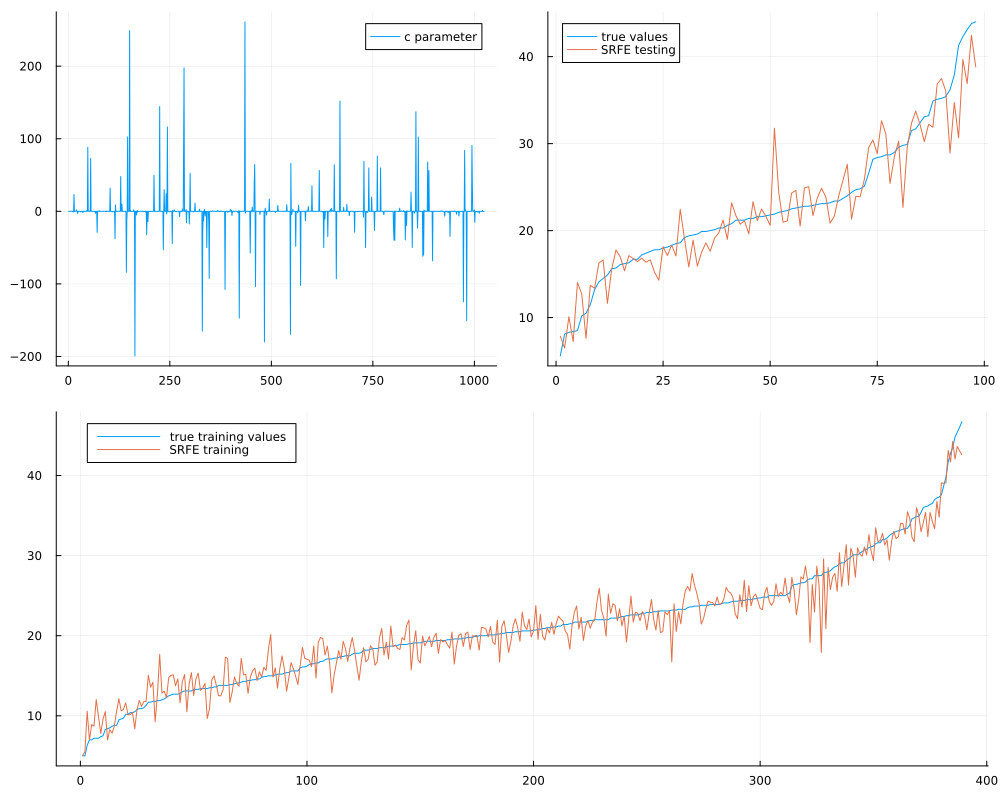

In [31]:
# Assemble all the models to test
# Hyper parameter testing cell for quantied
N= 2^15

SRFE = qsrfe.srfeRegressor(N=N,σ2=10.0,λ=0.00012, intercept=true)
RFE = qsrfe.rfeRegressor(N=N,σ2=10.0,λ=0.001, intercept=false)
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
model = SRFE
#training and evaluating
    #quantizaiton

c = qsrfe.fit(model, xtrain, ytrain,quant,max_iter=2000000, verbose=true) #
ytrainpred = qsrfe.predict(model,xtrain,quant)
ytestpred = qsrfe.predict(model, xtest,quant)

#     #no quantizaiton
# c = qsrfe.fit(model, xtrain, ytrain, verbose=true) #,max_iter=2000000
# ytrainpred = qsrfe.predict(model,xtrain)
# ytestpred = qsrfe.predict(model, xtest)

println("")
println("test rel: ",qsrfe.rel_L2_error(ytest,ytestpred)," train rel: ",qsrfe.rel_L2_error(ytrain,ytrainpred))
println("test abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("test mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
println("test rmse: ",qsrfe.rmse(ytest,ytestpred)," train rmse: ",qsrfe.rmse(ytrain,ytrainpred))

p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [8]:
# normal linear regression for comparison
lambda = 0.0000002
ridge = RidgeRegression(lambda; fit_intercept=true)

#A = hcat(xtrain)
A = hcat(xtrain,xtrain.^2,xtrain.^3)
# normal linear regression
# c = A \ ytrain ;
# # normal ridge regression
# lambda = 0.00001
# cRidge = (A' * A + lambda * I) \ (A'*ytrain)
c = MLJLinearModels.fit(ridge,A,ytrain)

#ytrainpred = hcat(xtrain,ones(size(xtrain,1))) * c
ytrainpred = hcat(xtrain,xtrain.^2,xtrain.^3,ones(size(xtrain,1))) * c

ytestpred = hcat(xtest,xtest.^2,xtest.^3,ones(size(xtest,1))) * c
println("")
println("test rel: ",qsrfe.rel_L2_error(ytest,ytestpred)," train rel: ",qsrfe.rel_L2_error(ytrain,ytrainpred))
println("test abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("test mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
# model = RFE
# p1 = plot(c[1:(end - model.intercept)],label="c parameter")
# p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
# plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
# p3 = plot(ytest[sortperm(ytest)], label="true values")
# plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
# p4 = plot(p1,p3,layout=2, size = (1000,400))
# plot(p4,p2,layout=(2,1) ,size=(1000,800))


test rel: 0.15796017282576505 train rel: 0.14240007206879143
test abs: 2.917169991953711 train abs: 2.383361431117994
test mse: 14.696819518048793 train mse: 10.156407867085619


In [ ]:
quant = βQ(K=256,β=1.5,λ=32,condense=true)
model = srfeRegressor(N=N,λ=λ, σ2=11.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14, 2^15]
λ = 0.00012
# level, 
df = qsrfe.create_df()
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

In [68]:
#
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
function objective(trial)
    @unpack λ = trial
    model = qsrfe.rfeRegressor(N=2^12,λ=λ, σ2=11.0,intercept=false)
    c = qsrfe.fit(model,xtrain,ytrain,quant;verbose=false)
    ytestpred = qsrfe.predict(model,xtest,quant)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.0000001..0.00001),
                        max_trials = 200);

HyperTuning.optimize(objective, scenario)
@unpack λ = scenario

Scenario: evaluated 200 trials.
          parameters: λ
   space cardinality: Huge!
           instances: 1
          batch_size: 28
             sampler: BCAPSampler{Xoshiro}
              pruner: NeverPrune
          max_trials: 200
           max_evals: 200
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬────────────┐
│     Trial │      Value │
│        46 │            │
├───────────┼────────────┤
│         λ │ 1.93863e-6 │
│    Pruned │      false │
│   Success │      false │
│ Objective │    7.43539 │
└───────────┴────────────┘


In [ ]:
λ = [ 0.000002,0.000002 , 0.000002,0.000007 , 0.000002, , ]

In [36]:
trials = 5
N = [2^15]
λ = 0.0001
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 32768: avg. test error: 0.099457979532047 avg. train error: 0.07033897839676798
abs. test error:2.003374888892825 abs. train error: 1.2857800667712185
mse. test error:7.945616932017723 mse train error: 3.0219652830071224
rel mse test error:0.1161165246293605 rel mse train error: 0.07766545019489232


In [37]:
trials = 5
N = [2^15]
λ = 0.00012
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 32768: avg. test error: 0.09928525885689693 avg. train error: 0.0725720568595174
abs. test error:2.0164194276888416 abs. train error: 1.3283515929454432
mse. test error:7.833304351954406 mse train error: 3.215381940940548
rel mse test error:0.11529524568177338 rel mse train error: 0.08011957007158933


In [38]:
trials = 5
N = [2^15]
λ = 0.00013
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 32768: avg. test error: 0.09845688408470059 avg. train error: 0.07440472815384462
abs. test error:2.0057813900108488 abs. train error: 1.36114745862127
mse. test error:8.019703701552043 mse train error: 3.3636965733813233
rel mse test error:0.1166712428519038 rel mse train error: 0.08194406857020822


In [39]:
trials = 5
N = [2^15]
λ = 0.00014
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 32768: avg. test error: 0.09763365737271115 avg. train error: 0.0751041429684848
abs. test error:1.9977659944386965 abs. train error: 1.3722688860437824
mse. test error:7.959560372367051 mse train error: 3.383179990607373
rel mse test error:0.11620201047934042 rel mse train error: 0.0821802050062693


In [ ]:
trials = 5
N = [2^15]
λ = 0.00014
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

In [8]:
println("2^8:", 2^8, " 2^9:", 2^9, " 2^10:", 2^10, " 2^11:", 2^11, " 2^12:", 2^12, " 2^13:", 2^13, " 2^14:", 2^14, " 2^15:", 2^15, " 2^16:", 2^16, " 2^17:", 2^17)
levels = [2^10, 2^11, 2^12, 2^13, 2^14, 2^15]
hyperopttrials = 50
trials = 10

2^8:256 2^9:512 2^10:1024 2^11:2048 2^12:4096 2^13:8192 2^14:16384 2^15:32768 2^16:65536 2^17:131072


10

In [62]:
0.0005 * 1.41^3

0.0014016104999999997

In [200]:

# RANDOM FEATURE EXPANSION
# level, rel L2, abs, mse
df_RFE = qsrfe.create_df([0., 0.0, 0.0, 0.0])
df = df_RFE
levels = [2^8,2^9,2^10, 2^11, 2^12, 2^13, 2^14]
hyperopttrials = 30
#first hyper opt finding
trials = 5

#λ = range(0.0001,0.006,length=7)
λ = [0.0005,0.0008, 0.001, 0.001, 0.002, 0.003, 0.005]
j=0
for level in levels
    j += 1
    print("current iter: ",level,": ")
    # function objective(trial)
    #     @unpack λ = trial
    #     model = qsrfe.srfeRegressor(N=level,λ=λ, σ2=11.0,intercept=true)
    #     c = qsrfe.fit(model,xtrain,ytrain;max_iter=2000000,verbose=false)
    #     ytestpred = qsrfe.predict(model,xtest)
    #     return qsrfe.mse(ytest,ytestpred)
    # end

    # scenario = Scenario(λ = (0.0001..0.1),
    #                         max_trials = hyperopttrials);
    # HyperTuning.optimize(objective, scenario)
    # @unpack λ = scenario
    # λ
    meanL2 = 0.0
    meanabs = 0.0
    meanmse = 0.0
    for i in 1:trials
        model = qsrfe.rfeRegressor(N=level,λ=λ[j], σ2=11.0,intercept=false)
        c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
        ytestpred = qsrfe.predict(model,xtest)
        meanL2 = meanL2 + qsrfe.rel_L2_error(ytest,ytestpred)/trials
        meanabs = meanabs + qsrfe.abs_error(ytest,ytestpred)/trials
        meanmse = meanmse + qsrfe.mse(ytest,ytestpred)/trials

    end
    push!(df,[level + 0., meanL2, meanabs, meanmse])
    println("avg. test error: ",meanmse)
end

current iter: 256: avg. test error: 8.298776255346526
current iter: 512: avg. test error: 7.72696085077026
current iter: 1024: avg. test error: 7.7472952730507645
current iter: 2048: avg. test error: 7.765463999992199
current iter: 4096: avg. test error: 7.790391331473938
current iter: 8192: avg. test error: 7.88136540178847
current iter: 16384: avg. test error: 8.044357029697387


In [46]:
trials = 5
N = [2^15]
λ = 0.008

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ, σ2=11.0, intercept=false)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model, (xtrain, xtest), (ytrain, ytest); trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 32768: avg. test error: 0.10491066584102807 avg. train error: 0.04989459895628751
abs. test error:2.048889359999779 abs. train error: 0.9161975405638133
mse. test error:8.206603515265936 mse train error: 1.600116725289631
rel mse test error:0.11803421814693374 rel mse train error: 0.05652171282458063


In [ ]:
# RFE quantization

In [71]:


trials = 5
N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11,2^12,2^13]
λ = 0.000002
i = 0
for n in N
    i += 1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ , σ2=11.0, intercept=false)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 64: avg. test error: 0.6253977109939617 avg. train error: 0.6173246473116895
abs. test error:13.505980826468274 abs. train error: 12.058336256019109
mse. test error:294.66499957294735 mse train error: 242.80555818078142
rel mse test error:0.6934496777994157 rel mse train error: 0.6823693450905025
current iter: 128: avg. test error: 0.375224054185623 avg. train error: 0.38384840322127406
abs. test error:8.31867223739005 abs. train error: 7.524341842904512
mse. test error:133.4693107108323 mse train error: 103.35489459432151
rel mse test error:0.47434324398424615 rel mse train error: 0.4517608231425337
current iter: 256: avg. test error: 0.2578939985797183 avg. train error: 0.26403179496177653
abs. test error:5.598402894761533 abs. train error: 5.005426695725383
mse. test error:57.52539847517376 mse train error: 46.54432405549179
rel mse test error:0.31160305254644804 rel mse train error: 0.3017899987617839
current iter: 512: avg. test error: 0.1869120379872377 avg. train e

In [74]:
trials = 5
N = [2^14]
λ = 0.000002
i = 0
for n in N
    i += 1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ , σ2=11.0, intercept=false)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 16384: avg. test error: 0.09941997268635319 avg. train error: 0.06605197917593392
abs. test error:1.9807465406328597 abs. train error: 1.2075578133744085
mse. test error:7.653705086340873 mse train error: 2.696334739114209
rel mse test error:0.11396317025415179 rel mse train error: 0.07337102996481197


In [75]:
trials = 5
N = [2^15]
λ = 0.000002
i = 0
for n in N
    i += 1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ , σ2=11.0, intercept=false)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 32768: avg. test error: 0.09934378787575172 avg. train error: 0.06286545987403047
abs. test error:1.995710551256316 abs. train error: 1.152372096819013
mse. test error:7.714260513015501 mse train error: 2.4609052717612014
rel mse test error:0.11441656366908375 rel mse train error: 0.07009240364434104


In [192]:
# setup dataframe for plotting later
# level, rel L2, abs, mse
df_SRFE = qsrfe.create_df([0.0, 0.0, 0.0, 0.0])
df = df_SRFE
hyperopttrials = 30
#first hyper opt finding
for level in levels
    print("current iter: ",level,": ")
    function objective(trial)
        @unpack λ = trial
        model = qsrfe.srfeRegressor(N=level,λ=λ, σ2=11.0,intercept=false)
        c = qsrfe.fit(model,xtrain,ytrain;max_iter=2000000,verbose=false)
        ytestpred = qsrfe.predict(model,xtest)
        return qsrfe.mse(ytest,ytestpred)
    end

    scenario = Scenario(λ = (0.0001..0.1),
                            max_trials = hyperopttrials);
    HyperTuning.optimize(objective, scenario)
    @unpack λ = scenario
    λ
    meanL2 = 0.0
    meanabs = 0.0
    meanmse = 0.0
    for i in 1:trials
        model = qsrfe.srfeRegressor(N=level,λ=λ, σ2=11.0,intercept=false)
        c = qsrfe.fit(model,xtrain,ytrain;max_iter=2000000,verbose=false)
        ytestpred = qsrfe.predict(model,xtest)
        meanL2 = meanL2 + qsrfe.mse(ytest,ytestpred)/trials
        meanabs = meanabs + qsrfe.abs_error(ytest,ytestpred)/trials
        meanmse = meanmse + qsrfe.mse(ytest,ytestpred)/trials

    end
    push!(df[level, meanL2, meanabs, meanmse])
    println("avg. test error: ",meanmse)
end

current iter: 256: 

MethodError: MethodError: no method matching getindex(::DataFrame, ::Int64, ::Float64, ::Float64, ::Float64)

Closest candidates are:
  getindex(::DataFrame, ::Integer, !Matched::Union{AbstractString, Symbol})
   @ DataFrames C:\Users\grsbe\.julia\packages\DataFrames\58MUJ\src\dataframe\dataframe.jl:520
  getindex(::DataFrame, ::Integer, !Matched::Union{Signed, Unsigned})
   @ DataFrames C:\Users\grsbe\.julia\packages\DataFrames\58MUJ\src\dataframe\dataframe.jl:506
  getindex(::AbstractDataFrame, ::Union{AbstractString, Integer, Symbol})
   @ DataFrames C:\Users\grsbe\.julia\packages\DataFrames\58MUJ\src\abstractdataframe\abstractdataframe.jl:2480
  ...


In [ ]:
level = 2^15
